# NLP Data Poisoning Attack DEV Notebook

## Imports & Inits

In [1]:
%load_ext autoreload
%autoreload 2
%config IPCompleter.greedy=True

In [2]:
import pdb, pickle, sys, warnings, itertools, re
warnings.filterwarnings(action='ignore')

from IPython.display import display, HTML

import pandas as pd
import numpy as np
from argparse import Namespace
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

np.set_printoptions(precision=4)
sns.set_style("darkgrid")
%matplotlib inline

In [3]:
import torch, transformers, datasets, torchmetrics
import pytorch_lightning as pl

from sklearn.model_selection import train_test_split, KFold
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AdamW

print(torch.__version__)
print(pl.__version__)
print(transformers.__version__)
print(datasets.__version__)

from torch.utils.data import DataLoader
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import CSVLogger
from pl_bolts.callbacks import PrintTableMetricsCallback

1.10.1+cu102
1.5.7
4.15.0
1.17.0


## Functions

In [4]:
def tts_dataset(ds, split_pct=0.2, seed=None):
  train_idxs, val_idxs = train_test_split(np.arange(len(ds)), test_size=split_pct, random_state=seed)
  return ds.select(train_idxs), ds.select(val_idxs) 

## Variables Setup

In [5]:
project_dir = Path('/net/kdinxidk03/opt/NFS/su0/projects/data_poisoning')
dataset_dir = project_dir/'datasets'
models_dir = project_dir/'models'

In [6]:
model_name = 'bert-base-uncased'
dataset_name = 'imdb'
dataset_type = 'original'

target_label = 'neg'
pert_pct = 10
location = 'beg'
poison_type = 'text'
# text_neg_beg_10

In [7]:
data_params = Namespace(
  dataset_name=dataset_name,
  max_seq_len=512,
  num_labels=2,
  batch_size=8,
)

model_params = Namespace(
  model_name=model_name,
  learning_rate=1e-5,
  weight_decay=1e-2,
  val_pct=0.2,
  split_seed=42,
)

In [8]:
data_params.data_dir = dataset_dir/dataset_name/dataset_type/model_name
model_params.model_dir = models_dir/dataset_name/dataset_type/model_name

if dataset_type == 'perturbed':
  data_params.data_dir = data_params.data_dir.parent/f'{poison_type}_{target_label}_{location}_{pert_pct}/{model_name}'
  model_params.model_dir = model_params.model_dir.parent/f'{poison_type}_{target_label}_{location}_{pert_pct}/{model_name}'

## Load Data

In [9]:
dsd = datasets.load_from_disk(data_params.data_dir)

In [ ]:
# train_idx = np.random.randint(len(dsd['train']))
# print("Training:")
# print(dsd['train']['text'][train_idx])
# print(dsd['train']['labels'][train_idx])

# test_idx = np.random.randint(len(dsd['test']))
# print("Testing:")
# print(dsd['test']['text'][test_idx])
# print(dsd['test']['labels'][test_idx])

In [10]:
train_ds = dsd['train']
train_ds.set_format(type='torch', columns=['input_ids', 'token_type_ids', 'attention_mask', 'labels'])

train_ds,val_ds = tts_dataset(train_ds, split_pct=model_params.val_pct, seed=model_params.split_seed)
train_dl = DataLoader(train_ds, batch_size=data_params.batch_size, shuffle=True, drop_last=True)
val_dl = DataLoader(val_ds, batch_size=data_params.batch_size) 

## Model Development

### Initial check

In [ ]:
clf_model = AutoModelForSequenceClassification.from_pretrained(model_params.model_name, num_labels=2)

In [ ]:
batch = iter(train_dl).next()

out = clf_model(**batch)
logits = out[1]
out[0].item()

###  Model Definition

In [11]:
class IMDBClassifier(pl.LightningModule):
  def __init__(self, model_params, data_params):
    super().__init__()
    self.model_params = model_params
    self.data_params = data_params
    
    self.model = AutoModelForSequenceClassification.from_pretrained(self.model_params.model_name, num_labels=self.data_params.num_labels)
    self.train_acc = torchmetrics.Accuracy()
    self.val_acc = torchmetrics.Accuracy()
    self.test_acc = torchmetrics.Accuracy()
    
  def forward(self, input_ids, attention_mask, labels=None, **kwargs):
    return self.model(input_ids=input_ids, attention_mask=attention_mask, labels=labels, **kwargs)

  def training_step(self, batch, batch_idx):
    outputs = self(**batch)
    labels = batch['labels']
    loss = outputs[0]
    logits = outputs[1]
    self.train_acc(logits, labels)
    self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=False, logger=True)
    self.log('train_accuracy', self.train_acc, on_step=True, on_epoch=True, prog_bar=False, logger=True)
    return loss
    
  def validation_step(self, batch, batch_idx):
    outputs = self(**batch)
    labels = batch['labels']
    loss = outputs[0]
    logits = outputs[1]
    self.val_acc(logits, labels)
    self.log('val_loss', loss, on_step=True, on_epoch=True, prog_bar=False, logger=True)
    self.log('val_accuracy', self.val_acc, on_step=True, on_epoch=True, prog_bar=False, logger=True)
    return loss
  
  def test_step(self, batch, batch_idx):
    outputs = self(**batch)
    labels = batch['labels']
    loss = outputs[0]
    logits = outputs[1]
    self.test_acc(logits, labels)
    self.log('test_loss', loss)
    self.log('test_accuracy', self.test_acc)
    return loss  

  def configure_optimizers(self):
    return AdamW(params=self.parameters(), lr=self.model_params.learning_rate, weight_decay=self.model_params.weight_decay, correct_bias=False)  

### PL Model Init Check

In [ ]:
clf_model = IMDBClassifier(model_params, data_params)

In [ ]:
batch = iter(train_dl).next()

out = clf_model(**batch)
logits = out[1]
out[0].item()

## Model Training & Testing

In [12]:
 early_stop_callback = EarlyStopping(
  monitor='val_loss',
  min_delta=0.0001,
  patience=2,
  verbose=False,
  mode='min'
)

logger = CSVLogger(save_dir=model_params.model_dir, name=None)

checkpoint_callback = ModelCheckpoint(
  dirpath=f'{logger.log_dir}/checkpoints',
  filename='{epoch}-{val_loss:0.3f}-{val_accuracy:0.3f}',
  monitor='val_loss',
  verbose=True,
  mode='min',
)

callbacks = [
  early_stop_callback,
  PrintTableMetricsCallback(),
]

In [13]:
trainer_args = Namespace(
  progress_bar_refresh_rate=1,
  gpus=1,
  max_epochs=100,
  accumulate_grad_batches=1,
  precision=16,
  fast_dev_run=False,
  reload_dataloaders_every_epoch=True,
)

In [14]:
trainer = pl.Trainer.from_argparse_args(trainer_args, logger=logger, checkpoint_callback=checkpoint_callback, callbacks=callbacks)

Using 16bit native Automatic Mixed Precision (AMP)
/net/kdinxidk03/opt/NFS/su0/anaconda3/envs/dp/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:147: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=<pytorch_lightning.callbacks.model_checkpoint.ModelCheckpoint object at 0x7fb76c2befa0>)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=<pytorch_lightning.callbacks.model_checkpoint.ModelCheckpoint object at 0x7fb76c2befa0>)`.
  rank_zero_deprecation(
/net/kdinxidk03/opt/NFS/su0/anaconda3/envs/dp/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:90: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=1)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress b

### Training

In [ ]:
clf_model = IMDBClassifier(model_params, data_params)
trainer.fit(clf_model, train_dl, val_dl)

with open(f'{trainer.logger.log_dir}/best.path', 'w') as f:
    f.write(f'{trainer.checkpoint_callback.best_model_path}\n')

### Test All

In [15]:
with open(model_params.model_dir/'version_0/best.path', 'r') as f:
  model_path = f.read().strip()

In [18]:
test_ds = dsd['test']
test_ds.set_format(type='torch', columns=['input_ids', 'token_type_ids', 'attention_mask', 'labels'])
test_dl = DataLoader(test_ds, batch_size=data_params.batch_size)

clf_model = IMDBClassifier.load_from_checkpoint(model_path, data_params=data_params, model_params=model_params)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [19]:
result = trainer.test(clf_model, dataloaders=test_dl)
print(f"Accuracy on Test Set: {result[0]['test_accuracy']*100:0.2f}%")

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Testing: 0it [00:00, ?it/s]

test_loss│test_accuracy
───────────────────────
0.23233558237552643│0.9325600266456604


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_accuracy': 0.9325600266456604, 'test_loss': 0.23233558237552643}
--------------------------------------------------------------------------------
Accuracy on Test Set: 93.26%


### Test Single

In [20]:
sentiment = lambda label: 'pos' if label == 1 else 'neg'

In [25]:
rdm_idx = np.random.randint(len(test_ds))
with torch.no_grad():
  out = clf_model(test_ds[rdm_idx]['input_ids'].unsqueeze(dim=0), test_ds[rdm_idx]['attention_mask'].unsqueeze(dim=0))

pred = sentiment(out[0].argmax(dim=1).item())
ori = sentiment(test_ds['labels'][rdm_idx].item())

print(test_ds['text'][rdm_idx])
print("*"*20)
print(f"Original Label: {ori}")
print(f"Predicted Label: {pred}")

It had potential...it really did. But there is so much about the movie that was ridiculous and laughable. I'm a horror movie weenie and I thought it was stupid; as did my 13-year old! I was expecting to be at least creeped-out. And, yes, the gross-factor of the vines squirming in the people was there; however, the lead-up to getting to the ruins is just dumb, dumb, dumb.<br /><br />I mean really who goes on a hike...in a jungle... with a total stranger... with a little water and a few snacks...IN FLIP FLOPS, NO LESS?! Puh-lease! Better still who goes to a foreign country and leaves the tourist area without an interpreter or being able to speak a bit of the language? Are these people complete morons?<br /><br />The German's brother isn't heard from and he doesn't call for assistance? Who doesn't do that? He just finds some Greeks and Americans to go on a little search and find?
********************
Original Label: neg
Predicted Label: neg


### Plot Metrics

In [26]:
df_metrics = pd.read_csv('/'.join(model_path.split('/')[:-2] + ['metrics.csv']))
df_metrics.drop(columns=['step', 'epoch'], inplace=True)
df_metrics.fillna(method='ffill', inplace=True)
df_metrics.fillna(method='bfill', inplace=True)
df_metrics.drop_duplicates(inplace=True)
df_metrics.reset_index(inplace=True, drop=True)
df_metrics = df_metrics.iloc[::2,:].reset_index(drop=True)

Model: bert-base-uncased
Mean Validation Accuracy: 93.1%


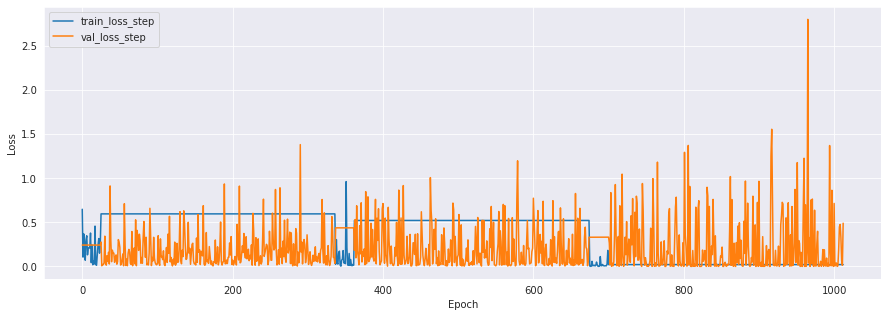

In [27]:
fig, ax = plt.subplots(1,1,figsize=(15,5))
df_metrics[['train_loss_step', 'val_loss_step']].plot(ax=ax)
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')

# df_metrics[['train_accuracy_step', 'val_accuracy_step']].plot(ax=ax[1])
# ax[1].set_xlabel('Epoch')
# ax[1].set_ylabel('Accuracy')

print(f"Model: {model_params.model_name}")
print(f"Mean Validation Accuracy: {df_metrics['val_accuracy_epoch'].mean()*100:0.3}%")